# Libraries

In [ ]:
import numpy as np 
import keras
from keras.datasets import cifar10
from collections import defaultdict
import random
from PIL import Image , ImageOps , ImageDraw
from keras.preprocessing.image import array_to_img
import matplotlib.pyplot as plt
import PIL
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers import MaxPooling2D
from keras.layers import ZeroPadding2D , GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.merge import add, Concatenate
from keras.models import Model
import cv2
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.models import Model
from keras import layers
from keras.layers import AveragePooling2D,Dropout,Flatten, Dense,MaxPooling2D,BatchNormalization,Activation,Conv2D,Input
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.engine.topology import get_source_inputs
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.preprocessing import image
import skimage.transform
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.regularizers import l2
from keras.models import Model
import tensorflow as tk
import tensorflow as tf
import keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time


# Perparing Datasets - 


*   Selecting the limited images (500 per label)
*   Label count ( 10 ) 
*   Normalizing the data
*   Plotting the graph (with images count vs label)


In [ ]:
def custom_cifar10_data(img_rows, img_cols):

    # Load cifar10 training and validation sets
    (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()

    # Resize training images
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:]])
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:,:,:,:]])

    # Transform targets to keras compatible format
    Y_train = np_utils.to_categorical(Y_train, num_classes)
    Y_valid = np_utils.to_categorical(Y_valid, num_classes)
    
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')

    # preprocess data
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return X_train, Y_train, X_valid, Y_valid

(x_train , y_train) , (x_test , y_test) = cifar10.load_data() 
print('X Train Shape : ' , x_train.shape)
print('Y Train Shape :' , y_train.shape)
print('X Test Shape : ' , x_test.shape)
print('Y Test Shape : ' , y_test.shape)

### Normalize the dataset
x_train = x_train / 255.0
x_test = x_test / 255.0

X Train Shape :  (50000, 32, 32, 3)
Y Train Shape : (50000, 1)
X Test Shape :  (10000, 32, 32, 3)
Y Test Shape :  (10000, 1)


# Modifing the Training Dataset - To reduce label Count




In [ ]:
def decreaseTrainData(x_train , y_train , count) : 
  unique_labels = np.unique(y_train)
  d = defaultdict(list)
  for i in range(x_train.shape[0]) : 
    key = y_train[i][0]
    if key in d.keys() and len(d[key]) > count : 
      continue
    d[y_train[i][0]].append(x_train[i])
    new_x_train = []
    new_y_train = []
    for key in d.keys() : 
      random.shuffle(d[key])
      d[key] = d[key][:count]
      new_x_train.extend(d[key])
      new_y_train.extend([key for i in range(count)])

  dataset = list(zip(new_x_train , new_y_train))
  random.shuffle(dataset)
  new_x_train , new_y_train = zip(*dataset)
  x_train = np.asarray(new_x_train , dtype = np.float32)
  y_train = np.asarray(new_y_train , dtype = np.float32)
  y_train = y_train.reshape(y_train.shape[0] , 1)

  return x_train , y_train

def getImages(x_train) : 
  fig, axes = plt.subplots(10,10, figsize=(8,8))
  for i,ax in enumerate(axes.flat):
      ax.imshow(array_to_img(x_train[i]))

def resizeImage(img , new_size) : 
  newImage = img.resize(new_size)
  return newImage

### Considering only the 500 labels from each class 
x_train , y_train = decreaseTrainData(x_train , y_train , 500)
### Get the shape of training labels
print('X Train Shape : ' , x_train.shape)
print('Y Train Shape :' , y_train.shape)
print('X Test Shape : ' , x_test.shape)
print('Y Test Shape : ' , y_test.shape)

# Weakly Augmentation

In [ ]:
def flipLeftRight(img) : 
  return img.transpose(Image.FLIP_LEFT_RIGHT)

def flipTopBottom(img) : 
  return img.transpose(Image.FLIP_TOP_BOTTOM)

def rotate90(img) :
  return img.transpose(Image.ROTATE_90)

def rotate180(img) : 
  return img.transpose(Image.ROTATE_180)

def rotate270(img) : 
  return img.transpose(Image.ROTATE_270)

def weak_augment_list() : 
  l = [(flipLeftRight) , (flipTopBottom) , (rotate90) , (rotate180) , (rotate270) ]
  return l


class WeakAugment : 
  def __init__(self , n = 3)  :
    self.n = n  
    self.augment_list = weak_augment_list()
  def __call__(self , img) : 
    ops = random.choices( self.augment_list , k = self.n)
    for op in ops : 
      img = op(img)
    return img


# Random Augmentation


*   ShearX , ShearY
*   TranslateX , TranslateXabs , TranslateY , TranslateYabs
*   Rotate , AutoContrast , Invert , Equilize , Flip
*   Solarize , SolarizeAdd , Polarize ,Contrast
*   Color , Brightness , Sharpness , Cutout , CutoutAbs
*   Sample Pairing , Identity




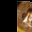

In [ ]:
def ShearX(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[0]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[1]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def Rotate(img, v):  # [-30, 30]
    assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)


def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)


def Invert(img, _):
    return PIL.ImageOps.invert(img)


def Equalize(img, _):
    return PIL.ImageOps.equalize(img)


def Flip(img, _):  # not from the paper
    return PIL.ImageOps.mirror(img)


def Solarize(img, v):  # [0, 256]
    assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)


def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(np.int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)


def Contrast(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Color(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)


def Brightness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Sharpness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def Cutout(img, v):  # [0, 60] => percentage: [0, 0.2]
    assert 0.0 <= v <= 0.2
    if v <= 0.:
        return img

    v = v * img.size[0]
    return CutoutAbs(img, v)


def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
    # assert 0 <= v <= 20
    if v < 0:
        return img
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)

    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)

    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    # color = (0, 0, 0)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def SamplePairing(imgs):  # [0, 0.4]
    def f(img1, v):
        i = np.random.choice(len(imgs))
        img2 = PIL.Image.fromarray(imgs[i])
        return PIL.Image.blend(img1, img2, v)

    return f


def Identity(img, v):
    return img


def augment_list():  # 16 oeprations and their ranges
    l = [
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (CutoutAbs, 0, 40),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    return l


class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""

    def __init__(self, alphastd, eigval, eigvec):
        self.alphastd = alphastd
        self.eigval = torch.Tensor(eigval)
        self.eigvec = torch.Tensor(eigvec)

    def __call__(self, img):
        if self.alphastd == 0:
            return img

        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone() \
            .mul(alpha.view(1, 3).expand(3, 3)) \
            .mul(self.eigval.view(1, 3).expand(3, 3)) \
            .sum(1).squeeze()

        return img.add(rgb.view(3, 1, 1).expand_as(img))


class CutoutDefault(object):
    
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img


class RandAugment:
    def __init__(self, n, m):
        self.n = n      # 16 Operations & their range values is defined
        self.m = m      # [0, 30]
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)

        return img


randAug = RandAugment(2 , 5 )
img = randAug.__call__(array_to_img(x_train[0]))
img  

# Visulaization

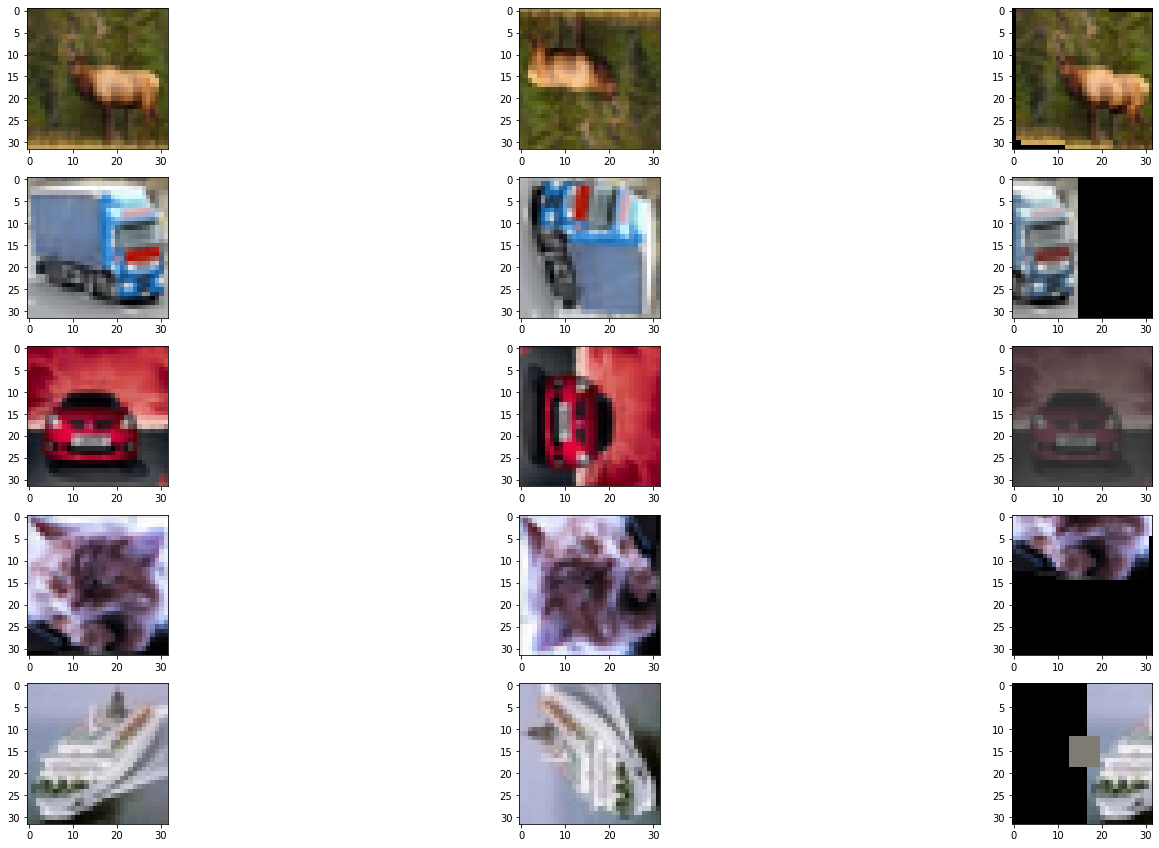

In [ ]:
no_image = 5
f, axarr = plt.subplots(no_image,3,figsize=(25, 15))
for i in range(no_image):

  randAug = RandAugment(2 , 5)
  img_strong = randAug.__call__(array_to_img(x_train[i]))

  weak_aug = WeakAugment(5)
  img_weak = weak_aug.__call__(array_to_img(x_train[i]))

  axarr[i,0].imshow(x_train[i])
  axarr[i,1].imshow(img_weak)
  axarr[i,2].imshow(img_strong)


# Supervised Learning Models

## VGG

In [ ]:
def vgg(output_label_cnt) :
  model = Sequential()
  model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(4096 , activation = 'relu'))
  model.add(Dense(4096 , activation = 'relu'))
  model.add(Dense(output_label_cnt , activation = 'softmax'))

  print(model.summary())
  return model

### For 10 labels class
vgg(10)

## Google Net

In [ ]:
def get_GoogLeNet( weights=None, include_top=False ):
  
  def conv2d_bn(x,filters,num_row,num_col,padding='same',
                strides=(1, 1),normalizer=True,activation='relu',name=None):
      if name is not None:
          conv_name = name + '_conv'
          bn_name = name + '_bn'
          act_name = name + '_act'
      else:
          conv_name = None
          bn_name = None
          act_name = None
      if K.image_data_format() == 'channels_first':
          bn_axis = 1
      else:
          bn_axis = 3
      x = Conv2D(
              filters, (num_row, num_col),
              strides=strides, padding=padding,
              use_bias=False, name=conv_name)(x)
      if normalizer:
          x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
      if activation:
          x = Activation(activation, name=act_name)(x)
      return x
  def concatenated_block(x, specs, channel_axis, name):
      (br0, br1, br2, br3) = specs   # ((64,), (96,128), (16,32), (32,))

      branch_0 = conv2d_bn(x, br0[0], 1, 1, name=name+"_Branch_0_a_1x1")

      branch_1 = conv2d_bn(x, br1[0], 1, 1, name=name+"_Branch_1_a_1x1")
      branch_1 = conv2d_bn(branch_1, br1[1], 3, 3, name=name+"_Branch_1_b_3x3")

      branch_2 = conv2d_bn(x, br2[0], 1, 1, name=name+"_Branch_2_a_1x1")
      branch_2 = conv2d_bn(branch_2, br2[1], 3, 3, name=name+"_Branch_2_b_3x3")

      branch_3 = MaxPooling2D( (3, 3), strides=(1, 1), padding='same', name=name+"_Branch_3_a_max")(x)  
      branch_3 = conv2d_bn(branch_3, br3[0], 1, 1, name=name+"_Branch_3_b_1x1")

      x = layers.concatenate(
          [branch_0, branch_1, branch_2, branch_3],
          axis=channel_axis,
          name=name+"_Concatenated")
      return x
  def InceptionV1(include_top=True,
                  weights='imagenet',
                  input_tensor=None,
                  input_shape=None,
                  pooling=None,
                  classes=1001):
      if weights not in {'imagenet', None}:
          raise ValueError('The `weights` argument should be either '
                           '`None` (random initialization) or `imagenet` '
                           '(pre-training on ImageNet).')

      if weights == 'imagenet' and include_top and classes != 1001:
          raise ValueError('If using `weights` as imagenet with `include_top`'
                           ' as true, `classes` should be 1001')
      input_shape = (224,224,3)
      img_input = Input(shape=input_shape)
      if K.image_data_format() == 'channels_first':
          channel_axis = 1
      else:
          channel_axis = 3

      x = img_input
      x = conv2d_bn(x,  64, 7, 7, strides=(2, 2), padding='same',  name='Conv2d_1a_7x7')  
      x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='MaxPool_2a_3x3')(x)  
      x = conv2d_bn(x,  64, 1, 1, strides=(1, 1), padding='same', name='Conv2d_2b_1x1')  
      x = conv2d_bn(x, 192, 3, 3, strides=(1, 1), padding='same', name='Conv2d_2c_3x3')  
      x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='MaxPool_3a_3x3')(x)  
      x = concatenated_block(x, (( 64,), ( 96,128), (16, 32), ( 32,)), channel_axis, 'Mixed_3b')
      x = concatenated_block(x, ((128,), (128,192), (32, 96), ( 64,)), channel_axis, 'Mixed_3c')
      x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='MaxPool_4a_3x3')(x)  
      x = concatenated_block(x, ((192,), ( 96,208), (16, 48), ( 64,)), channel_axis, 'Mixed_4b')
      x = concatenated_block(x, ((160,), (112,224), (24, 64), ( 64,)), channel_axis, 'Mixed_4c')
      x = concatenated_block(x, ((128,), (128,256), (24, 64), ( 64,)), channel_axis, 'Mixed_4d')
      x = concatenated_block(x, ((112,), (144,288), (32, 64), ( 64,)), channel_axis, 'Mixed_4e')
      x = concatenated_block(x, ((256,), (160,320), (32,128), (128,)), channel_axis, 'Mixed_4f')
      x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='MaxPool_5a_2x2')(x)  
      x = concatenated_block(x, ((256,), (160,320), (32,128), (128,)), channel_axis, 'Mixed_5b')
      x = concatenated_block(x, ((384,), (192,384), (48,128), (128,)), channel_axis, 'Mixed_5c')
      if include_top:
          x = AveragePooling2D((7, 7), strides=(1, 1), padding='valid')(x)  
          x = Dropout(0.2)(x)  # slim has keep_prob (@0.8), keras uses drop_fraction
          x = Conv2D(classes, (1, 1), strides=(1,1), padding='valid', use_bias=True, name='Logits')(x)
          x = Flatten(name='Logits_flat')(x)
          x = Activation('softmax', name='Predictions')(x)
      else:
          if pooling == 'avg':
              x = GlobalAveragePooling2D(name='global_pooling')(x)
          elif pooling == 'max':
              x = GlobalMaxPooling2D(    name='global_pooling')(x)
      if input_tensor is not None:
          inputs = get_source_inputs(input_tensor)
      else:
          inputs = img_input
      model = Model(inputs, x, name='inception_v1')
      # LOAD model weights
      if weights == 'imagenet':
          if K.image_data_format() == 'channels_first':
              if K.backend() == 'tensorflow':
                  warnings.warn('You are using the TensorFlow backend, yet you '
                                'are using the Theano '
                                'image data format convention '
                                '(`image_data_format="channels_first"`). '
                                'For best performance, set '
                                '`image_data_format="channels_last"` in '
                                'your Keras config '
                                'at ~/.keras/keras.json.')
          if include_top:
              weights_path = get_file(
                  'inception_v1_weights_tf_dim_ordering_tf_kernels.h5',
                  WEIGHTS_PATH,
                  cache_subdir='models',
                  md5_hash='723bf2f662a5c07db50d28c8d35b626d')
          else:
              weights_path = get_file(
                  'inception_v1_weights_tf_dim_ordering_tf_kernels_notop.h5',
                  WEIGHTS_PATH_NO_TOP,
                  cache_subdir='models',
                  md5_hash='6fa8ecdc5f6c402a59909437f0f5c975')
          model.load_weights(weights_path)
          if K.backend() == 'theano':
              convert_all_kernels_in_model(model)    
      return model
  inception_v1 = InceptionV1(include_top=False, weights=weights)
  
  return inception_v1




def googleNetModel() : 
  dropout_rate = 0.2
  nCluster = 10
  activation = 'relu'
  googlenet = get_GoogLeNet( weights = None, include_top=False )
  x = googlenet.output
  x = BatchNormalization()(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(dropout_rate)(x)
  x = Dense(nCluster, activation=activation)(x)
  model = Model(inputs=googlenet.input, outputs=x)
  return model

model = googleNetModel()
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_7x7_conv (Conv2D)     (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_7x7_bn (BatchNormaliz (None, 112, 112, 64) 192         Conv2d_1a_7x7_conv[0][0]         
__________________________________________________________________________________________________
Conv2d_1a_7x7_act (Activation)  (None, 112, 112, 64) 0           Conv2d_1a_7x7_bn[0][0]           
______________________________________________________________________________________________

## ResNet50

In [ ]:
def resNet50(output_lables) : 

  def convBlock(x , filters_1 , filters_2 , filters_3 ) : 
    x = Conv2D( filters_1 , (1,1) , padding = 'same' , activation = 'relu' )(x)
    x = Conv2D( filters_2 , (3,3) , padding = 'same' , activation = 'relu' )(x)
    x = Conv2D( filters_3 , (1,1) , padding = 'same' , activation = 'relu' )(x)
    return x 

  def combineConvBlock(x , n , filters_1 , filters_2 , filters_3) :
    for i in range(n) : 
      y = convBlock(x , filters_1 , filters_2 , filters_3)
      x = Concatenate(axis = -1)([x , y])

    return x 


  input_img = Input((224,224,3))
  x = ZeroPadding2D(padding = (3,3))(input_img)
  x = Conv2D(64 , (7,7) , strides = (2,2))(x)
  x = ZeroPadding2D(padding = (1,1))(input_img)
  x = MaxPooling2D(pool_size=(3,3) , strides=(2,2) , padding = 'valid' , data_format=None)(x)

  x = combineConvBlock(x , 3 , 64 , 64 , 256)
  x = ZeroPadding2D(padding = (1,1))(x)
  x = MaxPooling2D(pool_size=(3,3) , strides=(2,2) , padding = 'valid' , data_format=None)(x)

  x = combineConvBlock(x , 4 , 128 , 128 , 512)
  x = ZeroPadding2D(padding = (1,1))(x)
  x = MaxPooling2D(pool_size=(3,3) , strides=(2,2) , padding = 'valid' , data_format=None)(x)

  x = combineConvBlock(x , 6 , 256 , 256 , 1024)
  x = ZeroPadding2D(padding = (1,1))(x)
  x = MaxPooling2D(pool_size=(3,3) , strides=(2,2) , padding = 'valid' , data_format=None)(x)

  x = combineConvBlock(x , 3 , 512 , 512 , 2048)
  x = ZeroPadding2D(padding = (1,1))(x)
  x = MaxPooling2D(pool_size=(3,3) , strides=(2,2) , padding = 'valid' , data_format=None)(x)

  x = AveragePooling2D(pool_size=(7,7))(x)
  x = Flatten()(x)
  x = Dense(output_lables , activation = 'softmax')(x)


  model = Model(input_img , x)
  return model

model = resNet50(10)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 226, 226, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 112, 112, 3)  0           zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 112, 112, 64) 256         max_pooling2d_5[0][0]            
____________________________________________________________________________________________

## ResNet34

In [ ]:
def resNet34(output_lables) : 

  def convBlock(x , filters_1 , filters_2  ) : 
    x = Conv2D( filters_1 , (3,3) , padding = 'same' , activation = 'relu' )(x)
    x = Conv2D( filters_2 , (3,3) , padding = 'same' , activation = 'relu' )(x)
    return x 

  def combineConvBlock(x , n , filters_1 , filters_2 ) :
    for i in range(n) : 
      y = convBlock(x , filters_1 , filters_2 )
      x = Concatenate(axis = -1)([x , y])

    return x 


  input_img = Input((224,224,3))
  x = ZeroPadding2D(padding = (3,3))(input_img)
  x = Conv2D(64 , (7,7) , strides = (2,2))(x)
  x = ZeroPadding2D(padding = (1,1))(input_img)
  x = MaxPooling2D(pool_size=(3,3) , strides=(2,2) , padding = 'valid' , data_format=None)(x)

  x = combineConvBlock(x , 3 , 64 , 64 )
  x = ZeroPadding2D(padding = (1,1))(x)
  x = MaxPooling2D(pool_size=(3,3) , strides=(2,2) , padding = 'valid' , data_format=None)(x)

  x = combineConvBlock(x , 4 , 128 , 128 )
  x = ZeroPadding2D(padding = (1,1))(x)
  x = MaxPooling2D(pool_size=(3,3) , strides=(2,2) , padding = 'valid' , data_format=None)(x)

  x = combineConvBlock(x , 6 , 256 , 256 )
  x = ZeroPadding2D(padding = (1,1))(x)
  x = MaxPooling2D(pool_size=(3,3) , strides=(2,2) , padding = 'valid' , data_format=None)(x)

  x = combineConvBlock(x , 3 , 512 , 512 )
  x = ZeroPadding2D(padding = (1,1))(x)
  x = MaxPooling2D(pool_size=(3,3) , strides=(2,2) , padding = 'valid' , data_format=None)(x)

  x = AveragePooling2D(pool_size=(7,7))(x)
  x = Flatten()(x)
  x = Dense(output_lables , activation = 'softmax')(x)


  model = Model(input_img , x)
  return model

model = resNet34(10)
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 226, 226, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 112, 112, 3)  0           zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 112, 112, 64) 1792        max_pooling2d_10[0][0]           
____________________________________________________________________________________________

## VGG - CIFAR 10

In [ ]:
def small_vgg(num_classes):
        # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.

        model = Sequential()

        model.add(Conv2D(64, (3, 3), padding='same',
                         input_shape= (32 , 32 , 3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(128, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(256, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Dropout(0.5))
        model.add(Dense(num_classes))
        model.add(Activation('softmax'))
        return model

### For 10 labels class
model = small_vgg(10)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_229 (Conv2D)          (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_57 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_221 (Bat (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_230 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_58 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_222 (Bat (None, 32, 32, 64)        2

## GoogleNet - CIFAR 10

In [ ]:
def small_googlenet(output_label_cnt):
    
    input_img = Input(shape = (32, 32, 3))

    tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
    tower_1 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)

    tower_2 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
    tower_2 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
    tower_3 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_3)

    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    
    output = Flatten()(output)
    out    = Dense( output_label_cnt, activation='softmax')(output)

    model = Model(inputs = input_img, outputs = out)
    print(model.summary())
    return model

small_googlenet(10)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 32, 32, 64)   256         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_117 (Conv2D)             (None, 32, 32, 64)   256         input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 32, 32, 3)    0           input_6[0][0]                    
____________________________________________________________________________________________

## Resnet - 34 - CIFAR 10 

In [ ]:

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, Dense
from tensorflow.keras.layers import AveragePooling2D, Flatten

def stem(inputs):
    ''' Construct the Stem Convolutional Group 
        inputs : the input vector
    '''
    x = Conv2D(16, (3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
    
def learner(x, n_blocks):
    """ Construct the Learner
        x          : input to the learner
        n_blocks   : number of blocks in a group
    """
    # First Residual Block Group of 16 filters (Stage 1)
    # Quadruple (4X) the size of filters to fit the next Residual Group
    x = residual_group(x, 16, n_blocks, strides=(1, 1), n=4)

    # Second Residual Block Group of 64 filters (Stage 2)
    # Double (2X) the size of filters and reduce feature maps by 75% (strides=2) to fit the next Residual Group
    x = residual_group(x, 64, n_blocks, n=2)

    # Third Residual Block Group of 64 filters (Stage 3)
    # Double (2X) the size of filters and reduce feature maps by 75% (strides=2) to fit the next Residual Group
    x = residual_group(x, 128, n_blocks, n=2)
    return x

def residual_group(x, n_filters, n_blocks, strides=(2, 2), n=2):
    """ Construct a Residual Group
        x         : input into the group
        n_filters : number of filters for the group
        n_blocks  : number of residual blocks with identity link
        strides   : whether the projection block is a strided convolution
        n         : multiplier for the number of filters out
    """
    # Double the size of filters to fit the first Residual Group
    x = projection_block(x, n_filters, strides=strides, n=n)

    # Identity residual blocks
    for _ in range(n_blocks):
        x = identity_block(x, n_filters, n)
    return x
    
def identity_block(x, n_filters, n=2):
    """ Construct a Bottleneck Residual Block of Convolutions with Identity Shortcut
        x        : input into the block
        n_filters: number of filters
        n        : multiplier for filters out
    """
    # Save input vector (feature maps) for the identity link
    shortcut = x
    
    ## Construct the 1x1, 3x3, 1x1 residual block (fig 3c)

    # Dimensionality reduction
    x = Conv2D(n_filters, (1, 1), strides=(1, 1), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Bottleneck layer
    x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Dimensionality restoration - increase the number of output filters by 2X or 4X
    x = Conv2D(n_filters * n, (1, 1), strides=(1, 1), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # Add the identity link (input) to the output of the residual block
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def projection_block(x, n_filters, strides=(2,2), n=2):
    """ Construct Bottleneck Residual Block with Projection Shortcut
        Increase the number of filters by 2X (or 4X on first stage)
        x        : input into the block
        n_filters: number of filters
        strides  : whether the first convolution is strided
        n        : multiplier for number of filters out
    """
    # Construct the projection shortcut
    # Increase filters by 2X (or 4X) to match shape when added to output of block
    shortcut = Conv2D(n_filters * n, (1, 1), strides=strides, kernel_initializer='he_normal')(x)

    ## Construct the 1x1, 3x3, 1x1 convolution block

    # Dimensionality reduction
    x = Conv2D(n_filters, (1, 1), strides=(1,1), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Bottleneck layer - feature pooling when strides=(2, 2)
    x = Conv2D(n_filters, (3, 3), strides=strides, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)  
    
    # Dimensionality restoration - increase the number of filters by 2X (or 4X)
    x = Conv2D(n_filters * n, (1, 1), strides=(1, 1), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # Add the projection shortcut to the output of the residual block
    x = Add()([shortcut, x])
    x = ReLU()(x)
    return x
    
def classifier(x, n_classes):
    ''' Construct the Classifier
        x         : input into the classifier
        n_classes : number of classes
    '''
    # Pool the feature maps after the end of all the residual blocks
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling2D(pool_size=8)(x)
    
    # Flatten into 1D vector
    x = Flatten()(x)

    # Final Dense Outputting Layer 
    outputs = Dense(n_classes, activation='softmax', kernel_initializer='he_normal')(x)
    return outputs

#-------------------
# Model      | n   |
# ResNet20   | 2   |
# ResNet56   | 6   |
# ResNet110  | 12  |
# ResNet164  | 18  |
# ResNet1001 | 111 |
#
n = 18
depth =  n * 9 + 2
n_blocks = ((depth - 2) // 9) - 1

# The input tensor
inputs = Input(shape=(32, 32, 3))

# The Stem Convolution Group
x = stem(inputs)
   
# The learner
x = learner(x, n_blocks)

# The Classifier for 10 classes
outputs = classifier(x, 10)

# Instantiate the Model
resnet = Model(inputs, outputs)
resnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 32, 32, 16)   448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_57 (BatchNo (None, 32, 32, 16)   64          conv2d_63[0][0]                  
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 32, 32, 16)   0           batch_normalization_57[0][0]     
____________________________________________________________________________________________

# Shortcut to SSL Models

In [ ]:
from keras.applications.vgg16 import preprocess_input

'''
input_img = Input(shape = (32, 32, 3))

vgg = tf.keras.applications.VGG16(weights = None, input_tensor = input_img , classes = 10 , include_top = False)
for layer in vgg.layers :
  layer.trainable = True
x = Flatten()(vgg.output)
x = Dense(512 , activation= 'relu')(x)
x = BatchNormalization()(x)
outputs = Dense(10 , activation = 'softmax')(x)
vgg_model = Model(inputs = input_img , outputs = outputs)
vgg_model.summary()
'''

'''
input_img = Input(shape = (32, 32, 3))
resnet = tf.keras.applications.ResNet101V2(weights = None, input_tensor = input_img , classes = 10 , include_top = False)
for layer in resnet.layers :
  layer.trainable = True
x = Flatten()(resnet.output)
x = Dense(512 , activation= 'relu')(x)
x = BatchNormalization()(x)
outputs = Dense(10 , activation = 'softmax')(x)
resnet_model = Model(inputs = input_img , outputs = outputs)
resnet_model.summary()
'''

'''
input_img = Input(shape = (32, 32, 3))
vgg_19 = tf.keras.applications.VGG19(weights = None , input_tensor = input_img , classes = 10 , include_top = False)
for layer in vgg_19.layers :
  layer.trainable = True
x = Flatten()(vgg_19.output)
x = Dense(1024 , activation= 'relu')(x)
x = Dense(512 , activation= 'relu')(x)
x = Dense(256 , activation= 'relu')(x)
x = Dense(128 , activation= 'relu')(x)
outputs = Dense(10 , activation = 'softmax')(x)

vgg_model = Model(inputs = input_img , outputs = outputs)
vgg_model.summary()
'''

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
    
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
    
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
   
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


    
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

# Resnet 18

In [ ]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

resnet_model = ResNet18(10)
resnet_model.build(input_shape = (None,32,32,3))
resnet_model.summary()


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           multiple                  9472      
_________________________________________________________________
batch_normalization_40 (Batc multiple                  256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
resnet_block_16 (ResnetBlock multiple                  74368     
_________________________________________________________________
resnet_block_17 (ResnetBlock multiple        

# Distributing Training Dataset

*   Divide into two categories - Label , Unlabel
*   **Converting Label Encoding - One Hot Encoding**




In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
x_train , y_train = shuffle(x_train , y_train)
x_test , y_test = shuffle(x_test , y_test)
x_label , x_unlabel , y_label , y_unlabel = train_test_split(x_train , y_train , test_size = 0.1 , random_state = 42)
print("X Train Shape : " , x_train.shape)
print("Y Train Shape : " , y_train.shape)
print("X Label Shape : " , x_label.shape)
print("Y Label Shape : " , y_label.shape)
print("X UnLabel Shape : " , x_unlabel.shape)
print("Y UnLabel Shape : " , y_unlabel.shape)
print("X Test Shape : "  , x_test.shape)
print("Y Test Shape : " , y_test.shape)

### Label Enocding to One - Hot Encoding
from sklearn.preprocessing import OneHotEncoder
encoder_obj = OneHotEncoder(handle_unknown = 'ignore')
y_label = encoder_obj.fit_transform(y_label).toarray()
print("Y_Label Shape : " , y_label.shape)
y_test = encoder_obj.fit_transform(y_test).toarray()
print("Y_Test Shape : " , y_test.shape)
y_train = encoder_obj.fit_transform(y_train).toarray()
print("Y Train Shape : " , y_train.shape)


X Train Shape :  (50000, 32, 32, 3)
Y Train Shape :  (50000, 1)
X Label Shape :  (45000, 32, 32, 3)
Y Label Shape :  (45000, 1)
X UnLabel Shape :  (5000, 32, 32, 3)
Y UnLabel Shape :  (5000, 1)
X Test Shape :  (10000, 32, 32, 3)
Y Test Shape :  (10000, 1)
Y_Label Shape :  (45000, 10)
Y_Test Shape :  (10000, 10)
Y Train Shape :  (50000, 10)


In [ ]:
print("X Train : " , x_train[0])
print("X Label : " , x_label[0])
print("X Unlabel : " , x_unlabel[0])
print("X Test : " , x_test[0])

# Supervised Model Training
Train the model using VGG - CIFAR 10 and mapping the accuracy and test accuracy of the model.

In [ ]:
model = model
def custom_loss(y_true , y_pred) :
  global loss_unsupervised 
  ### Supervised Loss
  loss_supervised = tf.keras.losses.CategoricalCrossentropy()
  loss_supervised = loss_supervised(y_true, y_pred)
  ### Unsupervised Loss 
  return loss_supervised


          
### Saving the best model
model_weight_file_path = 'small_vgg.hdf5'
model_check_point = tf.keras.callbacks.ModelCheckpoint(
    filepath = model_weight_file_path , 
    save_weights_only = True , 
    monitor = 'val_accuracy' , 
    mode = 'max' , 
    save_best_only = True 
)

### Training the model 


model.compile(optimizer='Adam' , loss = custom_loss , metrics = ['accuracy'])
history = model.fit(x_label , y_label ,  epochs = 100 , batch_size = 128 , 
          validation_data = (x_test , y_test) , 
          callbacks = [model_check_point ], 
          verbose =1  )

'''
print("X Train Shape : " , x_train.shape)
print("Y Train Shape : " , y_train.shape)
model.compile(optimizer='Adam' , loss = custom_loss , metrics = ['accuracy'])
history = model.fit(x_train , y_train , batch_size = 50 , epochs = 100 , 
          validation_data = (x_test , y_test) , 
          callbacks = [model_check_point ], 
          verbose =1  )
'''

### Loading the best validation_accuracy weights 
model.load_weights(model_weight_file_path)

### Prediction

predict_y = model.predict(x = x_test , batch_size = 32 , verbose = 1)
test_accuracy = 0
for i in range(len(x_test)):
    if (np.argmax(predict_y[i]) == np.argmax(y_test[i])):
        test_accuracy += 1
test_accuracy = test_accuracy / len(x_test)*100

print("Test Accuracy: ", test_accuracy)

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

## Mapping Accuracy
plot_metric(history , 'accuracy')
## Loss 
plot_metric(history , 'loss')

Epoch 1/100
387/387 [==============================] - 9s 18ms/step - loss: 3.2837 - accuracy: 0.3236 - val_loss: 2.5517 - val_accuracy: 0.4580
Epoch 2/100
387/387 [==============================] - 6s 16ms/step - loss: 2.2380 - accuracy: 0.5583 - val_loss: 1.9516 - val_accuracy: 0.6095
Epoch 3/100
387/387 [==============================] - 6s 16ms/step - loss: 1.8065 - accuracy: 0.6473 - val_loss: 1.5807 - val_accuracy: 0.6912
Epoch 4/100
387/387 [==============================] - 6s 16ms/step - loss: 1.5222 - accuracy: 0.6956 - val_loss: 1.3501 - val_accuracy: 0.7270
Epoch 5/100
387/387 [==============================] - 6s 16ms/step - loss: 1.3393 - accuracy: 0.7240 - val_loss: 1.4250 - val_accuracy: 0.6858
Epoch 6/100
387/387 [==============================] - 6s 16ms/step - loss: 1.2351 - accuracy: 0.7428 - val_loss: 1.1478 - val_accuracy: 0.7608
Epoch 7/100
387/387 [==============================] - 6s 16ms/step - loss: 1.1245 - accuracy: 0.7648 - val_loss: 1.0970 - val_accuracy:

KeyboardInterrupt: ignored

## Custom Callbacks for the SSL

1.   **Custom Loss -**
Here we will combine the loss by both the models of supervised as well as unsupervised model. i.e. that the supervised loss will be (Cross - Entropy) and unlablled sample (Cross Entropy with the psudeo label only)
2.   Mapping Training / Validation Accuracy
3.   Mapping Training / Validation Loss





# Semi - Supervised Model Training
Adam , Threshold 0.9 ,  VGG Modified , 0.1

In [ ]:
from sklearn.utils import shuffle

### Random augmentation wrapper
def random_rotate_image_strong(image):
  randAug = RandAugment(2 , 6)
  image = randAug.__call__(array_to_img(image))
  image = img_to_array(image)
  return image
def tf_random_rotate_image_strong(image):
  im_shape = image.shape
  [image,] = tf.py_function(random_rotate_image_strong, [image], [tf.float32])
  image.set_shape(im_shape)
  return image/255.0
### Weak augmentation wrapper
def random_rotate_image_weak(image):
  #image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
  weak_aug = WeakAugment(3)
  image = weak_aug.__call__(array_to_img(image))
  image = img_to_array(image)
  return image
def tf_random_rotate_image_weak(image):
  im_shape = image.shape
  [image,] = tf.py_function(random_rotate_image_weak, [image], [tf.float32])
  image.set_shape(im_shape)
  return image/255.0  

model = model
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = keras.metrics.CategoricalAccuracy()
test_acc_metric = keras.metrics.CategoricalAccuracy()
epochs = 100


### Getting the shape
print("X Label Shape : " , x_label.shape)
print("Y Label Shape : " , y_label.shape)
print("X Unlabel Shape : ", x_unlabel.shape)
print("Y Unlable Shape : ", y_unlabel.shape)
print("X Test Shape : ", x_test.shape)
print("Y Test Shape : ", y_test.shape)

def custom_loss(y_true , y_pred , y_weak , y_strong) : 
  alpha = 1 
  threshold = 0.9
  y_weak_new = []
  y_strong_new = []
  ### Now getting only the y_weak with greater than threshold 
  for i in range(len(y_weak)) : 
    val = np.argmax(y_weak[i])
    if  y_weak[i][val] >= threshold :
      ### Creating Pseudo Label
      val = np.argmax(y_weak[i])
      y_pseudo = np.array([0 for j in range(len(y_weak[i]))])
      y_pseudo[val] = 1 
      ### Appending data to y_weak
      y_weak_new.append(y_pseudo)
      y_strong_new.append(y_strong[i])

  y_weak = np.array(y_weak_new)
  y_strong = np.array(y_strong_new)
        
  cateogrical_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  supervised_loss = cateogrical_cross_entropy(y_true , y_pred)

  if y_weak.size !=  0 : 
    unsupervised_loss = cateogrical_cross_entropy(y_weak , y_strong)
    custom_loss = alpha * unsupervised_loss + supervised_loss

  else : 
    custom_loss = supervised_loss

  return custom_loss

def custom_loss_test(y_true , y_pred) : 
  cateogrical_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  loss = cateogrical_cross_entropy(y_true , y_pred)
  return loss


for epoch in range(epochs) : 
  print("Epoch : " , epoch + 1 , end = " ")
  ### Time 
  start_time = time.time()
  ### Dataset
  x_label , y_label = shuffle(x_label , y_label)
  x_unlabel = shuffle(x_unlabel)
  x_unlabels =  tf.data.Dataset.from_tensor_slices(x_unlabel)
  x_unlabels_weak = x_unlabels.map(tf_random_rotate_image_weak)
  x_unlabels_strong = x_unlabels.map(tf_random_rotate_image_strong)
  labels = tf.data.Dataset.from_tensor_slices((x_label , y_label))
  unlabels = tf.data.Dataset.zip((x_unlabels_weak , x_unlabels_strong))
  train_dataset = tf.data.Dataset.zip((labels , unlabels)).batch(500)
  test_dataset = tf.data.Dataset.from_tensor_slices((x_test , y_test)).batch(500)
  
  for steps  , (labels , unlabels) in enumerate(train_dataset) : 
    batch_losses = []
    with tf.GradientTape() as tape : 
      logs_labels = model(labels[0] , training = True )
      logs_unlabels_weak = model(unlabels[0] , training = False )
      logs_unlabels_strong = model(unlabels[1] , training = True )

      loss = custom_loss(labels[1] , logs_labels , logs_unlabels_weak , logs_unlabels_strong)
      batch_losses.append(loss.numpy())
      train_acc_metric.update_state(labels[1] , logs_labels)

    
    grads = tape.gradient(loss , model.trainable_variables)
    optimizer.apply_gradients(zip(grads , model.trainable_variables))
    

  test_batch_losses = []
  for x_test_dash , y_test_dash in test_dataset : 
    y_predict = model(x_test_dash , training = False )
    loss = custom_loss_test(y_test_dash , y_predict)
    test_batch_losses.append(loss.numpy())
    ### Testing Accuracy
    test_acc_metric.update_state(y_test_dash , y_predict)

  ### Time End for Epoch
  end_time = time.time()
  train_acc = train_acc_metric.result()
  test_acc = test_acc_metric.result()
  print("Training acc: %4.f" % (float(train_acc),) , end = " ")
  print("Test acc: %.4f" % (float(test_acc),) , end = " ")
  print("Training Loss : " , np.mean(batch_losses) , end = " ")
  print("Test Loss : " , np.mean(test_batch_losses) , end = " ")
  print("Time : " , end_time - start_time )
  train_acc_metric.reset_states()
  test_acc_metric.reset_states()


X Label Shape :  (45000, 32, 32, 3)
Y Label Shape :  (45000, 10)
X Unlabel Shape :  (5000, 32, 32, 3)
Y Unlable Shape :  (5000, 1)
X Test Shape :  (10000, 32, 32, 3)
Y Test Shape :  (10000, 10)
Epoch :  1 Training acc:    0 Test acc: 0.1221 Training Loss :  2.4999669 Test Loss :  2.8400676 Time :  47.71237230300903
Epoch :  2 Training acc:    0 Test acc: 0.1835 Training Loss :  2.3830605 Test Loss :  2.227315 Time :  17.86898112297058
Epoch :  3 Training acc:    0 Test acc: 0.1883 Training Loss :  2.1112168 Test Loss :  2.2535567 Time :  17.240731954574585
Epoch :  4 Training acc:    0 Test acc: 0.2277 Training Loss :  1.8027402 Test Loss :  2.0776296 Time :  17.16632390022278
Epoch :  5 Training acc:    0 Test acc: 0.2214 Training Loss :  1.8936942 Test Loss :  2.0907345 Time :  17.100680589675903
Epoch :  6 Training acc:    0 Test acc: 0.2508 Training Loss :  1.7974924 Test Loss :  2.0520706 Time :  16.888553380966187
Epoch :  7 Training acc:    0 Test acc: 0.2494 Training Loss :  1.

# Model Training - 2nd
Adam , Threshold 0.9 ,  VGG Modified , 0.2

In [ ]:
def custom_cifar10_data(img_rows, img_cols):

    # Load cifar10 training and validation sets
    (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()

    # Resize training images
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:]])
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:,:,:,:]])

    # Transform targets to keras compatible format
    Y_train = np_utils.to_categorical(Y_train, num_classes)
    Y_valid = np_utils.to_categorical(Y_valid, num_classes)
    
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')

    # preprocess data
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return X_train, Y_train, X_valid, Y_valid

(x_train , y_train) , (x_test , y_test) = cifar10.load_data() 
print('X Train Shape : ' , x_train.shape)
print('Y Train Shape :' , y_train.shape)
print('X Test Shape : ' , x_test.shape)
print('Y Test Shape : ' , y_test.shape)

### Normalize the dataset
x_train = x_train / 255.0
x_test = x_test / 255.0


model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
    
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
    
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
   
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
x_train , y_train = shuffle(x_train , y_train)
x_test , y_test = shuffle(x_test , y_test)
x_label , x_unlabel , y_label , y_unlabel = train_test_split(x_train , y_train , test_size = 0.2 , random_state = 42)
print("X Train Shape : " , x_train.shape)
print("Y Train Shape : " , y_train.shape)
print("X Label Shape : " , x_label.shape)
print("Y Label Shape : " , y_label.shape)
print("X UnLabel Shape : " , x_unlabel.shape)
print("Y UnLabel Shape : " , y_unlabel.shape)
print("X Test Shape : "  , x_test.shape)
print("Y Test Shape : " , y_test.shape)

### Label Enocding to One - Hot Encoding
from sklearn.preprocessing import OneHotEncoder
encoder_obj = OneHotEncoder(handle_unknown = 'ignore')
y_label = encoder_obj.fit_transform(y_label).toarray()
print("Y_Label Shape : " , y_label.shape)
y_test = encoder_obj.fit_transform(y_test).toarray()
print("Y_Test Shape : " , y_test.shape)
y_train = encoder_obj.fit_transform(y_train).toarray()
print("Y Train Shape : " , y_train.shape)


from sklearn.utils import shuffle

### Random augmentation wrapper
def random_rotate_image_strong(image):
  randAug = RandAugment(2 , 6)
  image = randAug.__call__(array_to_img(image))
  image = img_to_array(image)
  return image
def tf_random_rotate_image_strong(image):
  im_shape = image.shape
  [image,] = tf.py_function(random_rotate_image_strong, [image], [tf.float32])
  image.set_shape(im_shape)
  return image/255.0
### Weak augmentation wrapper
def random_rotate_image_weak(image):
  #image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
  weak_aug = WeakAugment(3)
  image = weak_aug.__call__(array_to_img(image))
  image = img_to_array(image)
  return image
def tf_random_rotate_image_weak(image):
  im_shape = image.shape
  [image,] = tf.py_function(random_rotate_image_weak, [image], [tf.float32])
  image.set_shape(im_shape)
  return image/255.0  

model = model
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = keras.metrics.CategoricalAccuracy()
test_acc_metric = keras.metrics.CategoricalAccuracy()
epochs = 100


### Getting the shape
print("X Label Shape : " , x_label.shape)
print("Y Label Shape : " , y_label.shape)
print("X Unlabel Shape : ", x_unlabel.shape)
print("Y Unlable Shape : ", y_unlabel.shape)
print("X Test Shape : ", x_test.shape)
print("Y Test Shape : ", y_test.shape)

def custom_loss(y_true , y_pred , y_weak , y_strong) : 
  alpha = 1 
  threshold = 0.9
  y_weak_new = []
  y_strong_new = []
  ### Now getting only the y_weak with greater than threshold 
  for i in range(len(y_weak)) : 
    val = np.argmax(y_weak[i])
    if  y_weak[i][val] >= threshold :
      ### Creating Pseudo Label
      val = np.argmax(y_weak[i])
      y_pseudo = np.array([0 for j in range(len(y_weak[i]))])
      y_pseudo[val] = 1 
      ### Appending data to y_weak
      y_weak_new.append(y_pseudo)
      y_strong_new.append(y_strong[i])

  y_weak = np.array(y_weak_new)
  y_strong = np.array(y_strong_new)
        
  cateogrical_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  supervised_loss = cateogrical_cross_entropy(y_true , y_pred)

  if y_weak.size !=  0 : 
    unsupervised_loss = cateogrical_cross_entropy(y_weak , y_strong)
    custom_loss = alpha * unsupervised_loss + supervised_loss

  else : 
    custom_loss = supervised_loss

  return custom_loss

def custom_loss_test(y_true , y_pred) : 
  cateogrical_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  loss = cateogrical_cross_entropy(y_true , y_pred)
  return loss


for epoch in range(epochs) : 
  print("Epoch : " , epoch + 1 , end = " ")
  ### Time 
  start_time = time.time()
  ### Dataset
  x_label , y_label = shuffle(x_label , y_label)
  x_unlabel = shuffle(x_unlabel)
  x_unlabels =  tf.data.Dataset.from_tensor_slices(x_unlabel)
  x_unlabels_weak = x_unlabels.map(tf_random_rotate_image_weak)
  x_unlabels_strong = x_unlabels.map(tf_random_rotate_image_strong)
  labels = tf.data.Dataset.from_tensor_slices((x_label , y_label))
  unlabels = tf.data.Dataset.zip((x_unlabels_weak , x_unlabels_strong))
  train_dataset = tf.data.Dataset.zip((labels , unlabels)).batch(500)
  test_dataset = tf.data.Dataset.from_tensor_slices((x_test , y_test)).batch(500)
  
  for steps  , (labels , unlabels) in enumerate(train_dataset) : 
    batch_losses = []
    with tf.GradientTape() as tape : 
      logs_labels = model(labels[0] , training = True )
      logs_unlabels_weak = model(unlabels[0] , training = False )
      logs_unlabels_strong = model(unlabels[1] , training = False )

      loss = custom_loss(labels[1] , logs_labels , logs_unlabels_weak , logs_unlabels_strong)
      batch_losses.append(loss.numpy())
      train_acc_metric.update_state(labels[1] , logs_labels)

    
    grads = tape.gradient(loss , model.trainable_variables)
    optimizer.apply_gradients(zip(grads , model.trainable_variables))
    

  test_batch_losses = []
  for x_test_dash , y_test_dash in test_dataset : 
    y_predict = model(x_test_dash , training = False )
    loss = custom_loss_test(y_test_dash , y_predict)
    test_batch_losses.append(loss.numpy())
    ### Testing Accuracy
    test_acc_metric.update_state(y_test_dash , y_predict)

  ### Time End for Epoch
  end_time = time.time()
  train_acc = train_acc_metric.result()
  test_acc = test_acc_metric.result()
  print("Training acc: %4.f" % (float(train_acc),) , end = " ")
  print("Test acc: %.4f" % (float(test_acc),) , end = " ")
  print("Training Loss : " , np.mean(batch_losses) , end = " ")
  print("Test Loss : " , np.mean(test_batch_losses) , end = " ")
  print("Time : " , end_time - start_time )
  train_acc_metric.reset_states()
  test_acc_metric.reset_states()




X Train Shape :  (50000, 32, 32, 3)
Y Train Shape : (50000, 1)
X Test Shape :  (10000, 32, 32, 3)
Y Test Shape :  (10000, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0     

# Model Training - 2nd
Adam , Threshold 0.9 ,  VGG Modified , 0.3

In [ ]:
def custom_cifar10_data(img_rows, img_cols):

    # Load cifar10 training and validation sets
    (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()

    # Resize training images
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:]])
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:,:,:,:]])

    # Transform targets to keras compatible format
    Y_train = np_utils.to_categorical(Y_train, num_classes)
    Y_valid = np_utils.to_categorical(Y_valid, num_classes)
    
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')

    # preprocess data
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return X_train, Y_train, X_valid, Y_valid

(x_train , y_train) , (x_test , y_test) = cifar10.load_data() 
print('X Train Shape : ' , x_train.shape)
print('Y Train Shape :' , y_train.shape)
print('X Test Shape : ' , x_test.shape)
print('Y Test Shape : ' , y_test.shape)

### Normalize the dataset
x_train = x_train / 255.0
x_test = x_test / 255.0


model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
    
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
    
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
   
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
x_train , y_train = shuffle(x_train , y_train)
x_test , y_test = shuffle(x_test , y_test)
x_label , x_unlabel , y_label , y_unlabel = train_test_split(x_train , y_train , test_size = 0.3 , random_state = 42)
print("X Train Shape : " , x_train.shape)
print("Y Train Shape : " , y_train.shape)
print("X Label Shape : " , x_label.shape)
print("Y Label Shape : " , y_label.shape)
print("X UnLabel Shape : " , x_unlabel.shape)
print("Y UnLabel Shape : " , y_unlabel.shape)
print("X Test Shape : "  , x_test.shape)
print("Y Test Shape : " , y_test.shape)

### Label Enocding to One - Hot Encoding
from sklearn.preprocessing import OneHotEncoder
encoder_obj = OneHotEncoder(handle_unknown = 'ignore')
y_label = encoder_obj.fit_transform(y_label).toarray()
print("Y_Label Shape : " , y_label.shape)
y_test = encoder_obj.fit_transform(y_test).toarray()
print("Y_Test Shape : " , y_test.shape)
y_train = encoder_obj.fit_transform(y_train).toarray()
print("Y Train Shape : " , y_train.shape)


from sklearn.utils import shuffle

### Random augmentation wrapper
def random_rotate_image_strong(image):
  randAug = RandAugment(2 , 6)
  image = randAug.__call__(array_to_img(image))
  image = img_to_array(image)
  return image
def tf_random_rotate_image_strong(image):
  im_shape = image.shape
  [image,] = tf.py_function(random_rotate_image_strong, [image], [tf.float32])
  image.set_shape(im_shape)
  return image/255.0
### Weak augmentation wrapper
def random_rotate_image_weak(image):
  #image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
  weak_aug = WeakAugment(3)
  image = weak_aug.__call__(array_to_img(image))
  image = img_to_array(image)
  return image
def tf_random_rotate_image_weak(image):
  im_shape = image.shape
  [image,] = tf.py_function(random_rotate_image_weak, [image], [tf.float32])
  image.set_shape(im_shape)
  return image/255.0  

model = model
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = keras.metrics.CategoricalAccuracy()
test_acc_metric = keras.metrics.CategoricalAccuracy()
epochs = 100


### Getting the shape
print("X Label Shape : " , x_label.shape)
print("Y Label Shape : " , y_label.shape)
print("X Unlabel Shape : ", x_unlabel.shape)
print("Y Unlable Shape : ", y_unlabel.shape)
print("X Test Shape : ", x_test.shape)
print("Y Test Shape : ", y_test.shape)

def custom_loss(y_true , y_pred , y_weak , y_strong) : 
  alpha = 1 
  threshold = 0.9
  y_weak_new = []
  y_strong_new = []
  ### Now getting only the y_weak with greater than threshold 
  for i in range(len(y_weak)) : 
    val = np.argmax(y_weak[i])
    if  y_weak[i][val] >= threshold :
      ### Creating Pseudo Label
      val = np.argmax(y_weak[i])
      y_pseudo = np.array([0 for j in range(len(y_weak[i]))])
      y_pseudo[val] = 1 
      ### Appending data to y_weak
      y_weak_new.append(y_pseudo)
      y_strong_new.append(y_strong[i])

  y_weak = np.array(y_weak_new)
  y_strong = np.array(y_strong_new)
        
  cateogrical_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  supervised_loss = cateogrical_cross_entropy(y_true , y_pred)

  if y_weak.size !=  0 : 
    unsupervised_loss = cateogrical_cross_entropy(y_weak , y_strong)
    custom_loss = alpha * unsupervised_loss + supervised_loss

  else : 
    custom_loss = supervised_loss

  return custom_loss

def custom_loss_test(y_true , y_pred) : 
  cateogrical_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  loss = cateogrical_cross_entropy(y_true , y_pred)
  return loss


for epoch in range(epochs) : 
  print("Epoch : " , epoch + 1 , end = " ")
  ### Time 
  start_time = time.time()
  ### Dataset
  x_label , y_label = shuffle(x_label , y_label)
  x_unlabel = shuffle(x_unlabel)
  x_unlabels =  tf.data.Dataset.from_tensor_slices(x_unlabel)
  x_unlabels_weak = x_unlabels.map(tf_random_rotate_image_weak)
  x_unlabels_strong = x_unlabels.map(tf_random_rotate_image_strong)
  labels = tf.data.Dataset.from_tensor_slices((x_label , y_label))
  unlabels = tf.data.Dataset.zip((x_unlabels_weak , x_unlabels_strong))
  train_dataset = tf.data.Dataset.zip((labels , unlabels)).batch(500)
  test_dataset = tf.data.Dataset.from_tensor_slices((x_test , y_test)).batch(500)
  
  for steps  , (labels , unlabels) in enumerate(train_dataset) : 
    batch_losses = []
    with tf.GradientTape() as tape : 
      logs_labels = model(labels[0] , training = True )
      logs_unlabels_weak = model(unlabels[0] , training = False )
      logs_unlabels_strong = model(unlabels[1] , training = False )

      loss = custom_loss(labels[1] , logs_labels , logs_unlabels_weak , logs_unlabels_strong)
      batch_losses.append(loss.numpy())
      train_acc_metric.update_state(labels[1] , logs_labels)

    
    grads = tape.gradient(loss , model.trainable_variables)
    optimizer.apply_gradients(zip(grads , model.trainable_variables))
    

  test_batch_losses = []
  for x_test_dash , y_test_dash in test_dataset : 
    y_predict = model(x_test_dash , training = False )
    loss = custom_loss_test(y_test_dash , y_predict)
    test_batch_losses.append(loss.numpy())
    ### Testing Accuracy
    test_acc_metric.update_state(y_test_dash , y_predict)

  ### Time End for Epoch
  end_time = time.time()
  train_acc = train_acc_metric.result()
  test_acc = test_acc_metric.result()
  print("Training acc: %4.f" % (float(train_acc),) , end = " ")
  print("Test acc: %.4f" % (float(test_acc),) , end = " ")
  print("Training Loss : " , np.mean(batch_losses) , end = " ")
  print("Test Loss : " , np.mean(test_batch_losses) , end = " ")
  print("Time : " , end_time - start_time )
  train_acc_metric.reset_states()
  test_acc_metric.reset_states()




X Train Shape :  (50000, 32, 32, 3)
Y Train Shape : (50000, 1)
X Test Shape :  (10000, 32, 32, 3)
Y Test Shape :  (10000, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0       

# Model Training - 2nd
Adam , Threshold 0.9 ,  VGG Modified , 0.4

In [ ]:
def custom_cifar10_data(img_rows, img_cols):

    # Load cifar10 training and validation sets
    (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()

    # Resize training images
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:]])
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:,:,:,:]])

    # Transform targets to keras compatible format
    Y_train = np_utils.to_categorical(Y_train, num_classes)
    Y_valid = np_utils.to_categorical(Y_valid, num_classes)
    
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')

    # preprocess data
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return X_train, Y_train, X_valid, Y_valid

(x_train , y_train) , (x_test , y_test) = cifar10.load_data() 
print('X Train Shape : ' , x_train.shape)
print('Y Train Shape :' , y_train.shape)
print('X Test Shape : ' , x_test.shape)
print('Y Test Shape : ' , y_test.shape)

### Normalize the dataset
x_train = x_train / 255.0
x_test = x_test / 255.0


model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
    
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
    
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
   
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
x_train , y_train = shuffle(x_train , y_train)
x_test , y_test = shuffle(x_test , y_test)
x_label , x_unlabel , y_label , y_unlabel = train_test_split(x_train , y_train , test_size = 0.4 , random_state = 42)
print("X Train Shape : " , x_train.shape)
print("Y Train Shape : " , y_train.shape)
print("X Label Shape : " , x_label.shape)
print("Y Label Shape : " , y_label.shape)
print("X UnLabel Shape : " , x_unlabel.shape)
print("Y UnLabel Shape : " , y_unlabel.shape)
print("X Test Shape : "  , x_test.shape)
print("Y Test Shape : " , y_test.shape)

### Label Enocding to One - Hot Encoding
from sklearn.preprocessing import OneHotEncoder
encoder_obj = OneHotEncoder(handle_unknown = 'ignore')
y_label = encoder_obj.fit_transform(y_label).toarray()
print("Y_Label Shape : " , y_label.shape)
y_test = encoder_obj.fit_transform(y_test).toarray()
print("Y_Test Shape : " , y_test.shape)
y_train = encoder_obj.fit_transform(y_train).toarray()
print("Y Train Shape : " , y_train.shape)


from sklearn.utils import shuffle

### Random augmentation wrapper
def random_rotate_image_strong(image):
  randAug = RandAugment(2 , 6)
  image = randAug.__call__(array_to_img(image))
  image = img_to_array(image)
  return image
def tf_random_rotate_image_strong(image):
  im_shape = image.shape
  [image,] = tf.py_function(random_rotate_image_strong, [image], [tf.float32])
  image.set_shape(im_shape)
  return image/255.0
### Weak augmentation wrapper
def random_rotate_image_weak(image):
  #image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
  weak_aug = WeakAugment(3)
  image = weak_aug.__call__(array_to_img(image))
  image = img_to_array(image)
  return image
def tf_random_rotate_image_weak(image):
  im_shape = image.shape
  [image,] = tf.py_function(random_rotate_image_weak, [image], [tf.float32])
  image.set_shape(im_shape)
  return image/255.0  

model = model
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = keras.metrics.CategoricalAccuracy()
test_acc_metric = keras.metrics.CategoricalAccuracy()
epochs = 100


### Getting the shape
print("X Label Shape : " , x_label.shape)
print("Y Label Shape : " , y_label.shape)
print("X Unlabel Shape : ", x_unlabel.shape)
print("Y Unlable Shape : ", y_unlabel.shape)
print("X Test Shape : ", x_test.shape)
print("Y Test Shape : ", y_test.shape)

def custom_loss(y_true , y_pred , y_weak , y_strong) : 
  alpha = 1 
  threshold = 0.9
  y_weak_new = []
  y_strong_new = []
  ### Now getting only the y_weak with greater than threshold 
  for i in range(len(y_weak)) : 
    val = np.argmax(y_weak[i])
    if  y_weak[i][val] >= threshold :
      ### Creating Pseudo Label
      val = np.argmax(y_weak[i])
      y_pseudo = np.array([0 for j in range(len(y_weak[i]))])
      y_pseudo[val] = 1 
      ### Appending data to y_weak
      y_weak_new.append(y_pseudo)
      y_strong_new.append(y_strong[i])

  y_weak = np.array(y_weak_new)
  y_strong = np.array(y_strong_new)
        
  cateogrical_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  supervised_loss = cateogrical_cross_entropy(y_true , y_pred)

  if y_weak.size !=  0 : 
    unsupervised_loss = cateogrical_cross_entropy(y_weak , y_strong)
    custom_loss = alpha * unsupervised_loss + supervised_loss

  else : 
    custom_loss = supervised_loss

  return custom_loss

def custom_loss_test(y_true , y_pred) : 
  cateogrical_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  loss = cateogrical_cross_entropy(y_true , y_pred)
  return loss


for epoch in range(epochs) : 
  print("Epoch : " , epoch + 1 , end = " ")
  ### Time 
  start_time = time.time()
  ### Dataset
  x_label , y_label = shuffle(x_label , y_label)
  x_unlabel = shuffle(x_unlabel)
  x_unlabels =  tf.data.Dataset.from_tensor_slices(x_unlabel)
  x_unlabels_weak = x_unlabels.map(tf_random_rotate_image_weak)
  x_unlabels_strong = x_unlabels.map(tf_random_rotate_image_strong)
  labels = tf.data.Dataset.from_tensor_slices((x_label , y_label))
  unlabels = tf.data.Dataset.zip((x_unlabels_weak , x_unlabels_strong))
  train_dataset = tf.data.Dataset.zip((labels , unlabels)).batch(500)
  test_dataset = tf.data.Dataset.from_tensor_slices((x_test , y_test)).batch(500)
  
  for steps  , (labels , unlabels) in enumerate(train_dataset) : 
    batch_losses = []
    with tf.GradientTape() as tape : 
      logs_labels = model(labels[0] , training = True )
      logs_unlabels_weak = model(unlabels[0] , training = False )
      logs_unlabels_strong = model(unlabels[1] , training = False )

      loss = custom_loss(labels[1] , logs_labels , logs_unlabels_weak , logs_unlabels_strong)
      batch_losses.append(loss.numpy())
      train_acc_metric.update_state(labels[1] , logs_labels)

    
    grads = tape.gradient(loss , model.trainable_variables)
    optimizer.apply_gradients(zip(grads , model.trainable_variables))
    

  test_batch_losses = []
  for x_test_dash , y_test_dash in test_dataset : 
    y_predict = model(x_test_dash , training = False )
    loss = custom_loss_test(y_test_dash , y_predict)
    test_batch_losses.append(loss.numpy())
    ### Testing Accuracy
    test_acc_metric.update_state(y_test_dash , y_predict)

  ### Time End for Epoch
  end_time = time.time()
  train_acc = train_acc_metric.result()
  test_acc = test_acc_metric.result()
  print("Training acc: %4.f" % (float(train_acc),) , end = " ")
  print("Test acc: %.4f" % (float(test_acc),) , end = " ")
  print("Training Loss : " , np.mean(batch_losses) , end = " ")
  print("Test Loss : " , np.mean(test_batch_losses) , end = " ")
  print("Time : " , end_time - start_time )
  train_acc_metric.reset_states()
  test_acc_metric.reset_states()




X Train Shape :  (50000, 32, 32, 3)
Y Train Shape : (50000, 1)
X Test Shape :  (10000, 32, 32, 3)
Y Test Shape :  (10000, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0     

# Model Training - 2nd
Adam , Threshold 0.9 ,  VGG Modified , 0.5

In [ ]:
def custom_cifar10_data(img_rows, img_cols):

    # Load cifar10 training and validation sets
    (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()

    # Resize training images
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:]])
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:,:,:,:]])

    # Transform targets to keras compatible format
    Y_train = np_utils.to_categorical(Y_train, num_classes)
    Y_valid = np_utils.to_categorical(Y_valid, num_classes)
    
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')

    # preprocess data
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return X_train, Y_train, X_valid, Y_valid

(x_train , y_train) , (x_test , y_test) = cifar10.load_data() 
print('X Train Shape : ' , x_train.shape)
print('Y Train Shape :' , y_train.shape)
print('X Test Shape : ' , x_test.shape)
print('Y Test Shape : ' , y_test.shape)

### Normalize the dataset
x_train = x_train / 255.0
x_test = x_test / 255.0


model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
    
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
    
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
   
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
x_train , y_train = shuffle(x_train , y_train)
x_test , y_test = shuffle(x_test , y_test)
x_label , x_unlabel , y_label , y_unlabel = train_test_split(x_train , y_train , test_size = 0.4 , random_state = 42)
print("X Train Shape : " , x_train.shape)
print("Y Train Shape : " , y_train.shape)
print("X Label Shape : " , x_label.shape)
print("Y Label Shape : " , y_label.shape)
print("X UnLabel Shape : " , x_unlabel.shape)
print("Y UnLabel Shape : " , y_unlabel.shape)
print("X Test Shape : "  , x_test.shape)
print("Y Test Shape : " , y_test.shape)

### Label Enocding to One - Hot Encoding
from sklearn.preprocessing import OneHotEncoder
encoder_obj = OneHotEncoder(handle_unknown = 'ignore')
y_label = encoder_obj.fit_transform(y_label).toarray()
print("Y_Label Shape : " , y_label.shape)
y_test = encoder_obj.fit_transform(y_test).toarray()
print("Y_Test Shape : " , y_test.shape)
y_train = encoder_obj.fit_transform(y_train).toarray()
print("Y Train Shape : " , y_train.shape)


from sklearn.utils import shuffle

### Random augmentation wrapper
def random_rotate_image_strong(image):
  randAug = RandAugment(2 , 6)
  image = randAug.__call__(array_to_img(image))
  image = img_to_array(image)
  return image
def tf_random_rotate_image_strong(image):
  im_shape = image.shape
  [image,] = tf.py_function(random_rotate_image_strong, [image], [tf.float32])
  image.set_shape(im_shape)
  return image/255.0
### Weak augmentation wrapper
def random_rotate_image_weak(image):
  #image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
  weak_aug = WeakAugment(3)
  image = weak_aug.__call__(array_to_img(image))
  image = img_to_array(image)
  return image
def tf_random_rotate_image_weak(image):
  im_shape = image.shape
  [image,] = tf.py_function(random_rotate_image_weak, [image], [tf.float32])
  image.set_shape(im_shape)
  return image/255.0  

model = model
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = keras.metrics.CategoricalAccuracy()
test_acc_metric = keras.metrics.CategoricalAccuracy()
epochs = 100


### Getting the shape
print("X Label Shape : " , x_label.shape)
print("Y Label Shape : " , y_label.shape)
print("X Unlabel Shape : ", x_unlabel.shape)
print("Y Unlable Shape : ", y_unlabel.shape)
print("X Test Shape : ", x_test.shape)
print("Y Test Shape : ", y_test.shape)

def custom_loss(y_true , y_pred , y_weak , y_strong) : 
  alpha = 1 
  threshold = 0.9
  y_weak_new = []
  y_strong_new = []
  ### Now getting only the y_weak with greater than threshold 
  for i in range(len(y_weak)) : 
    val = np.argmax(y_weak[i])
    if  y_weak[i][val] >= threshold :
      ### Creating Pseudo Label
      val = np.argmax(y_weak[i])
      y_pseudo = np.array([0 for j in range(len(y_weak[i]))])
      y_pseudo[val] = 1 
      ### Appending data to y_weak
      y_weak_new.append(y_pseudo)
      y_strong_new.append(y_strong[i])

  y_weak = np.array(y_weak_new)
  y_strong = np.array(y_strong_new)
        
  cateogrical_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  supervised_loss = cateogrical_cross_entropy(y_true , y_pred)

  if y_weak.size !=  0 : 
    unsupervised_loss = cateogrical_cross_entropy(y_weak , y_strong)
    custom_loss = alpha * unsupervised_loss + supervised_loss

  else : 
    custom_loss = supervised_loss

  return custom_loss

def custom_loss_test(y_true , y_pred) : 
  cateogrical_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  loss = cateogrical_cross_entropy(y_true , y_pred)
  return loss


for epoch in range(epochs) : 
  print("Epoch : " , epoch + 1 , end = " ")
  ### Time 
  start_time = time.time()
  ### Dataset
  x_label , y_label = shuffle(x_label , y_label)
  x_unlabel = shuffle(x_unlabel)
  x_unlabels =  tf.data.Dataset.from_tensor_slices(x_unlabel)
  x_unlabels_weak = x_unlabels.map(tf_random_rotate_image_weak)
  x_unlabels_strong = x_unlabels.map(tf_random_rotate_image_strong)
  labels = tf.data.Dataset.from_tensor_slices((x_label , y_label))
  unlabels = tf.data.Dataset.zip((x_unlabels_weak , x_unlabels_strong))
  train_dataset = tf.data.Dataset.zip((labels , unlabels)).batch(500)
  test_dataset = tf.data.Dataset.from_tensor_slices((x_test , y_test)).batch(500)
  
  for steps  , (labels , unlabels) in enumerate(train_dataset) : 
    batch_losses = []
    with tf.GradientTape() as tape : 
      logs_labels = model(labels[0] , training = True )
      logs_unlabels_weak = model(unlabels[0] , training = False )
      logs_unlabels_strong = model(unlabels[1] , training = False )

      loss = custom_loss(labels[1] , logs_labels , logs_unlabels_weak , logs_unlabels_strong)
      batch_losses.append(loss.numpy())
      train_acc_metric.update_state(labels[1] , logs_labels)

    
    grads = tape.gradient(loss , model.trainable_variables)
    optimizer.apply_gradients(zip(grads , model.trainable_variables))
    

  test_batch_losses = []
  for x_test_dash , y_test_dash in test_dataset : 
    y_predict = model(x_test_dash , training = False )
    loss = custom_loss_test(y_test_dash , y_predict)
    test_batch_losses.append(loss.numpy())
    ### Testing Accuracy
    test_acc_metric.update_state(y_test_dash , y_predict)

  ### Time End for Epoch
  end_time = time.time()
  train_acc = train_acc_metric.result()
  test_acc = test_acc_metric.result()
  print("Training acc: %4.f" % (float(train_acc),) , end = " ")
  print("Test acc: %.4f" % (float(test_acc),) , end = " ")
  print("Training Loss : " , np.mean(batch_losses) , end = " ")
  print("Test Loss : " , np.mean(test_batch_losses) , end = " ")
  print("Time : " , end_time - start_time )
  train_acc_metric.reset_states()
  test_acc_metric.reset_states()




X Train Shape :  (50000, 32, 32, 3)
Y Train Shape : (50000, 1)
X Test Shape :  (10000, 32, 32, 3)
Y Test Shape :  (10000, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 32)        0     

# Model Training - 2nd
Adam , Threshold 0.9 ,  VGG Modified , 0.95

In [ ]:
def custom_cifar10_data(img_rows, img_cols):

    # Load cifar10 training and validation sets
    (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()

    # Resize training images
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:]])
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:,:,:,:]])

    # Transform targets to keras compatible format
    Y_train = np_utils.to_categorical(Y_train, num_classes)
    Y_valid = np_utils.to_categorical(Y_valid, num_classes)
    
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')

    # preprocess data
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return X_train, Y_train, X_valid, Y_valid

(x_train , y_train) , (x_test , y_test) = cifar10.load_data() 
print('X Train Shape : ' , x_train.shape)
print('Y Train Shape :' , y_train.shape)
print('X Test Shape : ' , x_test.shape)
print('Y Test Shape : ' , y_test.shape)

### Normalize the dataset
x_train = x_train / 255.0
x_test = x_test / 255.0


model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
    
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
    
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
   
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
x_train , y_train = shuffle(x_train , y_train)
x_test , y_test = shuffle(x_test , y_test)
x_label , x_unlabel , y_label , y_unlabel = train_test_split(x_train , y_train , test_size = 0.95 , random_state = 42)
print("X Train Shape : " , x_train.shape)
print("Y Train Shape : " , y_train.shape)
print("X Label Shape : " , x_label.shape)
print("Y Label Shape : " , y_label.shape)
print("X UnLabel Shape : " , x_unlabel.shape)
print("Y UnLabel Shape : " , y_unlabel.shape)
print("X Test Shape : "  , x_test.shape)
print("Y Test Shape : " , y_test.shape)

### Label Enocding to One - Hot Encoding
from sklearn.preprocessing import OneHotEncoder
encoder_obj = OneHotEncoder(handle_unknown = 'ignore')
y_label = encoder_obj.fit_transform(y_label).toarray()
print("Y_Label Shape : " , y_label.shape)
y_test = encoder_obj.fit_transform(y_test).toarray()
print("Y_Test Shape : " , y_test.shape)
y_train = encoder_obj.fit_transform(y_train).toarray()
print("Y Train Shape : " , y_train.shape)


from sklearn.utils import shuffle

### Random augmentation wrapper
def random_rotate_image_strong(image):
  randAug = RandAugment(2 , 6)
  image = randAug.__call__(array_to_img(image))
  image = img_to_array(image)
  return image
def tf_random_rotate_image_strong(image):
  im_shape = image.shape
  [image,] = tf.py_function(random_rotate_image_strong, [image], [tf.float32])
  image.set_shape(im_shape)
  return image/255.0
### Weak augmentation wrapper
def random_rotate_image_weak(image):
  #image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
  weak_aug = WeakAugment(3)
  image = weak_aug.__call__(array_to_img(image))
  image = img_to_array(image)
  return image
def tf_random_rotate_image_weak(image):
  im_shape = image.shape
  [image,] = tf.py_function(random_rotate_image_weak, [image], [tf.float32])
  image.set_shape(im_shape)
  return image/255.0  

model = model
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = keras.metrics.CategoricalAccuracy()
test_acc_metric = keras.metrics.CategoricalAccuracy()
epochs = 200


### Getting the shape
print("X Label Shape : " , x_label.shape)
print("Y Label Shape : " , y_label.shape)
print("X Unlabel Shape : ", x_unlabel.shape)
print("Y Unlable Shape : ", y_unlabel.shape)
print("X Test Shape : ", x_test.shape)
print("Y Test Shape : ", y_test.shape)

def custom_loss(y_true , y_pred , y_weak , y_strong) : 
  alpha = 1 
  threshold = 0.9
  y_weak_new = []
  y_strong_new = []
  ### Now getting only the y_weak with greater than threshold 
  for i in range(len(y_weak)) : 
    val = np.argmax(y_weak[i])
    if  y_weak[i][val] >= threshold :
      ### Creating Pseudo Label
      val = np.argmax(y_weak[i])
      y_pseudo = np.array([0 for j in range(len(y_weak[i]))])
      y_pseudo[val] = 1 
      ### Appending data to y_weak
      y_weak_new.append(y_pseudo)
      y_strong_new.append(y_strong[i])

  y_weak = np.array(y_weak_new)
  y_strong = np.array(y_strong_new)
        
  cateogrical_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  supervised_loss = cateogrical_cross_entropy(y_true , y_pred)

  if y_weak.size !=  0 : 
    unsupervised_loss = cateogrical_cross_entropy(y_weak , y_strong)
    custom_loss = alpha * unsupervised_loss + supervised_loss

  else : 
    custom_loss = supervised_loss

  return custom_loss

def custom_loss_test(y_true , y_pred) : 
  cateogrical_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  loss = cateogrical_cross_entropy(y_true , y_pred)
  return loss


for epoch in range(epochs) : 
  print("Epoch : " , epoch + 1 , end = " ")
  ### Time 
  start_time = time.time()
  ### Dataset
  x_label , y_label = shuffle(x_label , y_label)
  x_unlabel = shuffle(x_unlabel)
  x_unlabels =  tf.data.Dataset.from_tensor_slices(x_unlabel)
  x_unlabels_weak = x_unlabels.map(tf_random_rotate_image_weak)
  x_unlabels_strong = x_unlabels.map(tf_random_rotate_image_strong)
  labels = tf.data.Dataset.from_tensor_slices((x_label , y_label))
  unlabels = tf.data.Dataset.zip((x_unlabels_weak , x_unlabels_strong))
  train_dataset = tf.data.Dataset.zip((labels , unlabels)).batch(500)
  test_dataset = tf.data.Dataset.from_tensor_slices((x_test , y_test)).batch(500)
  
  for steps  , (labels , unlabels) in enumerate(train_dataset) : 
    batch_losses = []
    with tf.GradientTape() as tape : 
      logs_labels = model(labels[0] , training = True )
      logs_unlabels_weak = model(unlabels[0] , training = False )
      logs_unlabels_strong = model(unlabels[1] , training = True )

      loss = custom_loss(labels[1] , logs_labels , logs_unlabels_weak , logs_unlabels_strong)
      batch_losses.append(loss.numpy())
      train_acc_metric.update_state(labels[1] , logs_labels)

    
    grads = tape.gradient(loss , model.trainable_variables)
    optimizer.apply_gradients(zip(grads , model.trainable_variables))
    

  test_batch_losses = []
  for x_test_dash , y_test_dash in test_dataset : 
    y_predict = model(x_test_dash , training = False )
    loss = custom_loss_test(y_test_dash , y_predict)
    test_batch_losses.append(loss.numpy())
    ### Testing Accuracy
    test_acc_metric.update_state(y_test_dash , y_predict)

  ### Time End for Epoch
  end_time = time.time()
  train_acc = train_acc_metric.result()
  test_acc = test_acc_metric.result()
  print("Training acc: %4.f" % (float(train_acc),) , end = " ")
  print("Test acc: %.4f" % (float(test_acc),) , end = " ")
  print("Training Loss : " , np.mean(batch_losses) , end = " ")
  print("Test Loss : " , np.mean(test_batch_losses) , end = " ")
  print("Time : " , end_time - start_time )
  train_acc_metric.reset_states()
  test_acc_metric.reset_states()




X Train Shape :  (50000, 32, 32, 3)
Y Train Shape : (50000, 1)
X Test Shape :  (10000, 32, 32, 3)
Y Test Shape :  (10000, 1)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_21 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_22 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 32)        0     

# Stopping Colab from Runtime

Write in Console



In [ ]:
function ClickConnect(){
  console.log("Connnect Clicked - Start"); 
  document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
  console.log("Connnect Clicked - End"); 
};
setInterval(ClickConnect, 60000)

ClickConnect()

# Results

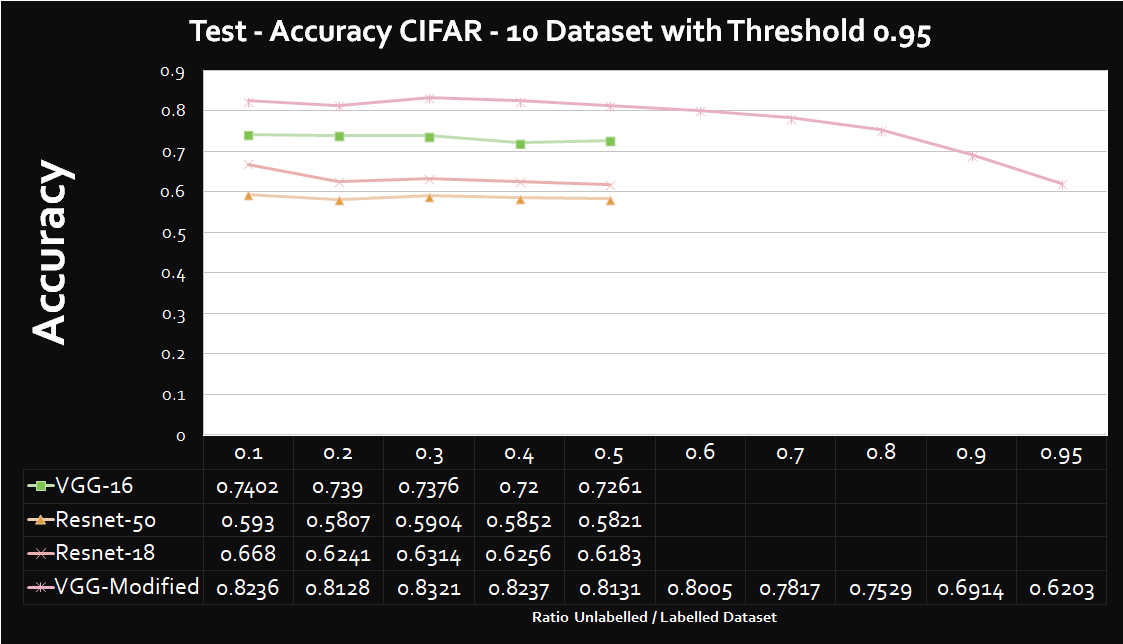

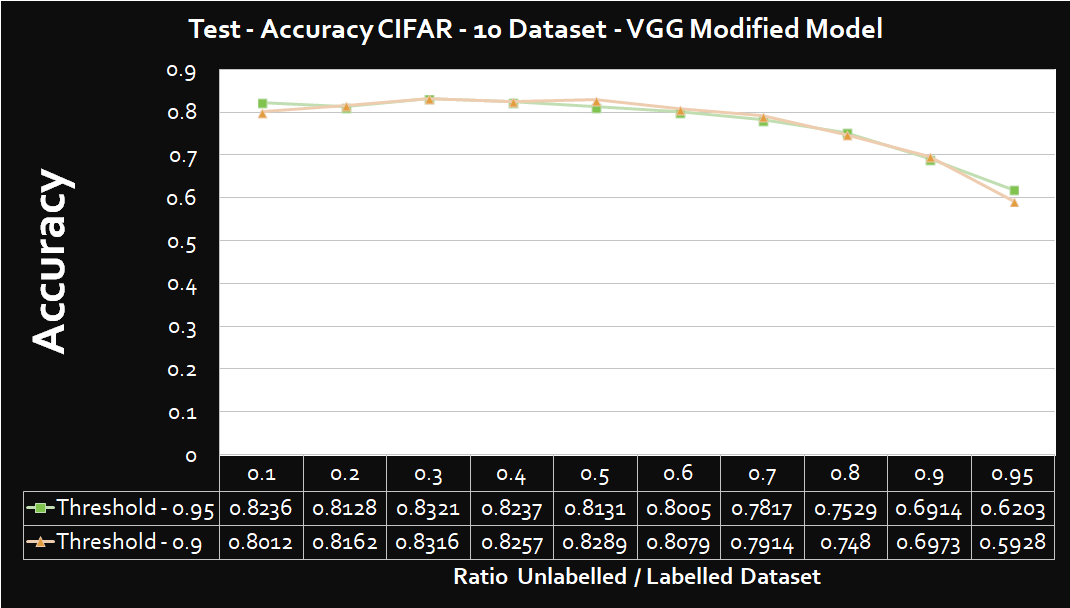

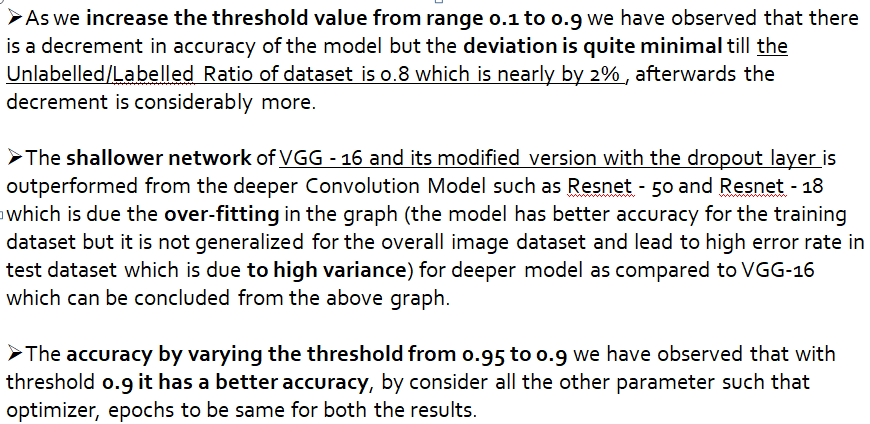